<a href="https://colab.research.google.com/github/Chenyuju/chen/blob/master/Classification(Heart_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import OneVsRest

In [43]:
import findspark
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

visualization = pd.read_csv('/content/chen/vheart.csv')
visualization.columns = ['age', 'sex', 'cp', 'trestbps', 'chol',
              'fbs', 'restecg', 'thalach', 'exang', 
              'oldpeak', 'slope', 'ca', 'thal', 'target']

heart_data = spark.read.format('com.databricks.spark.csv').\
                              options(header='true', \
                              inferschema='true') \
                .load("/content/chen/heart.csv",header=True);

heart_data.show(10)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|
| 58|  0|  0|     100| 248|  0|      0|    122|    0|    1.0|    1|  0|   2|     1|
| 58|  1|  0|     114| 318|  0|      2|    140|    0|    4.4|    0|  3|   1|     0|
| 55|  1|  0|     160| 289|  0|      0|    145|    1|    0.8|    1|  1|   3|     0|
| 46|  1|  0|     120| 249|  0|      0|    144|    0|    0.8|    2|  0|   3|

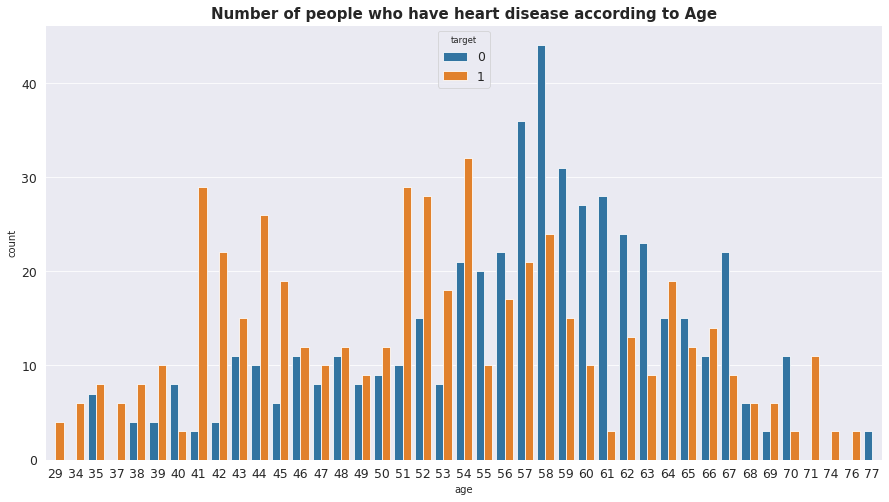

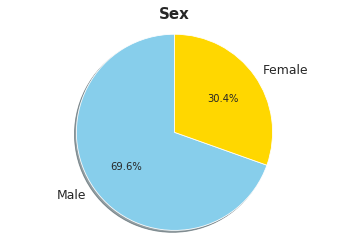

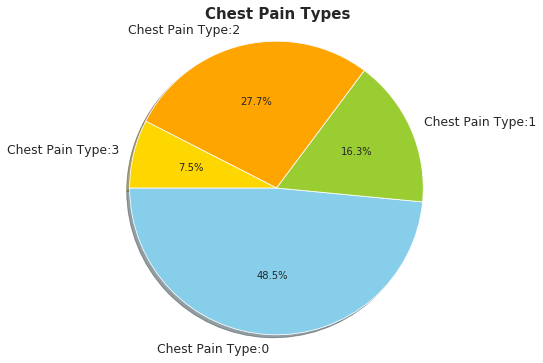

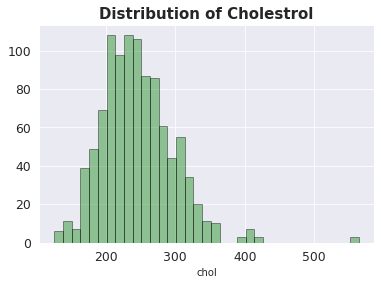

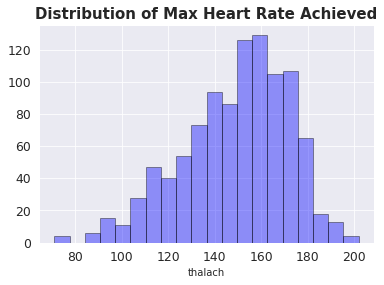

In [44]:
plt.figure(figsize=(15,8))
sns.set_context("paper", font_scale = 1.4, rc = {"font.size": 10,"axes.titlesize": 15,"axes.labelsize": 10}) 

sns.countplot(x='age',data = visualization, hue = 'target')
plt.title('Number of people who have heart disease according to Age', fontweight='bold')
plt.show()

male =len(visualization[visualization['sex'] == 1])
female = len(visualization[visualization['sex']== 0])
labels = 'Male','Female'
sizes = [male,female]
colors = ['skyblue', 'gold']
explode = (0, 0) 
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Sex', fontweight='bold')
plt.show()

plt.figure(figsize=(8,6))
labels = 'Chest Pain Type:0','Chest Pain Type:1','Chest Pain Type:2','Chest Pain Type:3'
sizes = [len(visualization[visualization['cp'] == 0]),len(visualization[visualization['cp'] == 1]),
         len(visualization[visualization['cp'] == 2]),
         len(visualization[visualization['cp'] == 3])]
colors = ['skyblue', 'yellowgreen','orange','gold']
explode = (0.01, 0.01, 0.01, 0.01) 
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title('Chest Pain Types', fontweight='bold')
plt.show()

sns.distplot(visualization['chol'], kde=False, color='g', hist_kws=dict(edgecolor="k", linewidth=1))
plt.title('Distribution of Cholestrol', fontweight='bold')
plt.show()

sns.distplot(visualization['thalach'], kde=False, color='b', hist_kws=dict(edgecolor="k", linewidth=1))
plt.title('Distribution of Max Heart Rate Achieved', fontweight='bold')
plt.show()

In [45]:
def transData(data):
  return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

transformed = transData(heart_data)
trainingData, testData = transformed.randomSplit([0.7, 0.3])
transformed.sample(False, 0.1, 123).show(10)

heart_data.count(),trainingData.count(),testData.count()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[51.0,1.0,0.0,140...|    0|
|[50.0,1.0,2.0,129...|    1|
|[41.0,1.0,1.0,135...|    1|
|[29.0,1.0,1.0,130...|    1|
|[37.0,0.0,2.0,120...|    1|
|[58.0,1.0,2.0,140...|    1|
|[62.0,0.0,0.0,140...|    0|
|[43.0,0.0,2.0,122...|    1|
|[62.0,1.0,1.0,120...|    0|
|[64.0,0.0,0.0,180...|    1|
+--------------------+-----+
only showing top 10 rows



(1025, 703, 322)

In [0]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(transformed)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(transformed)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

evaluator_lr_ovr = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

In [0]:
lr = LogisticRegression()

model_lr = lr.fit(trainingData)
predictions_lr = model_lr.transform(testData)

accuracy_lr = evaluator_lr_ovr.evaluate(predictions_lr)

In [0]:
ovr = OneVsRest(classifier=lr)

model_ovr= ovr.fit(trainingData)
predictions_ovr = model_ovr.transform(testData)

accuracy_ovr = evaluator_lr_ovr.evaluate(predictions_ovr)

In [0]:
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

pipeline_dt = Pipeline(stages=[labelIndexer, featureIndexer, dt])
model_dt = pipeline_dt.fit(trainingData)
predictions_dt = model_dt.transform(testData)

accuracy_dt = evaluator.evaluate(predictions_dt)
treeModel = model_dt.stages[2]

In [0]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=30)

pipeline_rf = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])
model_rf = pipeline_rf.fit(trainingData)
predictions_rf = model_rf.transform(testData)

accuracy_rf = evaluator.evaluate(predictions_rf)
rfModel = model_rf.stages[2]

In [0]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=30)

pipeline_gbt = Pipeline(stages=[labelIndexer, featureIndexer, gbt])
model_gbt = pipeline_gbt.fit(trainingData)
predictions_gbt = model_gbt.transform(testData)

accuracy_gbt = evaluator.evaluate(predictions_gbt)
gbtModel = model_gbt.stages[2]

In [0]:
nb = NaiveBayes(smoothing=1.0, labelCol="indexedLabel", featuresCol="indexedFeatures")

pipeline_nb = Pipeline(stages=[labelIndexer, featureIndexer, nb, labelConverter])
model_nb = pipeline_nb.fit(trainingData)
predictions_nb = model_nb.transform(testData)

accuracy_nb = evaluator.evaluate(predictions_nb)

In [0]:
layers = [13, 40, 35, 30, 25, 20, 20, 15, 10, 5, 2]

mlp = MultilayerPerceptronClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=100, layers=layers, blockSize=128, seed=1234)

pipeline_mlp = Pipeline(stages=[labelIndexer, featureIndexer, mlp, labelConverter])
model_mlp = pipeline_mlp.fit(trainingData)
predictions_mlp = model_mlp.transform(testData)

accuracy_mlp = evaluator.evaluate(predictions_mlp)

In [54]:
print("Test Error of Logistic Regression = %g \n" % (1.0 - accuracy_lr))

print("Test Error of One-Vs-Rest = %g \n" % (1.0 - accuracy_ovr))

print("Test Error of Decision Tree = %g" % (1.0 - accuracy_dt))
print(treeModel, "\n")

print("Test Error of Random Forest = %g" % (1.0 - accuracy_rf))
print(rfModel, "\n") 

print("Test Error of Gradient-Boosted Tree = %g" % (1.0 - accuracy_gbt))
print(gbtModel, "\n")

print("Test Error of Naive Bayes = %g \n" % (1.0 - accuracy_nb))

print("Test Error of Multilayer-Perceptron = %g" % (1.0 - accuracy_mlp))

Test Error of Logistic Regression = 0.189441 

Test Error of One-Vs-Rest = 0.189441 

Test Error of Decision Tree = 0.102484
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_1939e89379f2) of depth 5 with 53 nodes 

Test Error of Random Forest = 0.0931677
RandomForestClassificationModel (uid=RandomForestClassifier_807f148144bf) with 30 trees 

Test Error of Gradient-Boosted Tree = 0.0310559
GBTClassificationModel (uid=GBTClassifier_18405928dfb9) with 30 trees 

Test Error of Naive Bayes = 0.263975 

Test Error of Multilayer-Perceptron = 0.347826


Accuracy :  81.06 %        89.75 %         90.68 %         96.89 %        73.6 %       65.22 %        81.06 %        


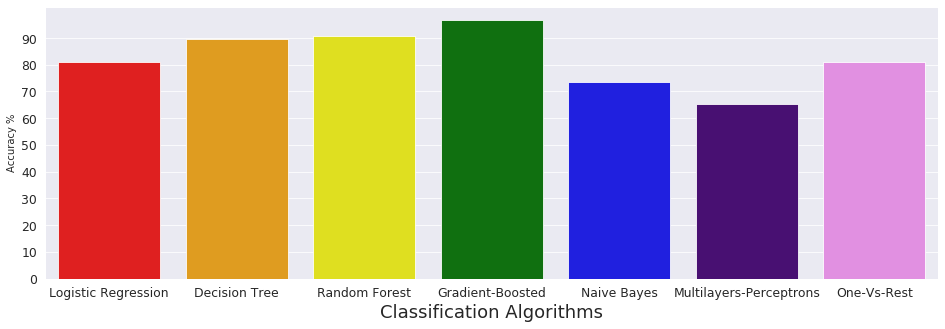

In [55]:
methods = ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient-Boosted", "Naive Bayes", "Multilayers-Perceptrons", "One-Vs-Rest"]
accuracy = [float("{0:.2f}".format(accuracy_lr*100)), float("{0:.2f}".format(accuracy_dt*100)), float("{0:.2f}".format(accuracy_rf*100)), float("{0:.2f}".format(accuracy_gbt*100)), 
            float("{0:.2f}".format(accuracy_nb*100)), float("{0:.2f}".format(accuracy_mlp*100)), float("{0:.2f}".format(accuracy_ovr*100))]

colors = ["red", "orange", "yellow", "green", "blue", "indigo", "violet"]
sns.set_style("darkgrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
print("Accuracy : ", accuracy[0], "%       ", accuracy[1], "%        ", accuracy[2], "%        ", accuracy[3], "%       ",
     accuracy[4], "%      ", accuracy[5], "%       ", accuracy[6], "%        ")
plt.ylabel("Accuracy %")
plt.xlabel("Classification Algorithms", fontsize=18)
sns.barplot(x=methods, y=accuracy, palette=colors)
plt.show()

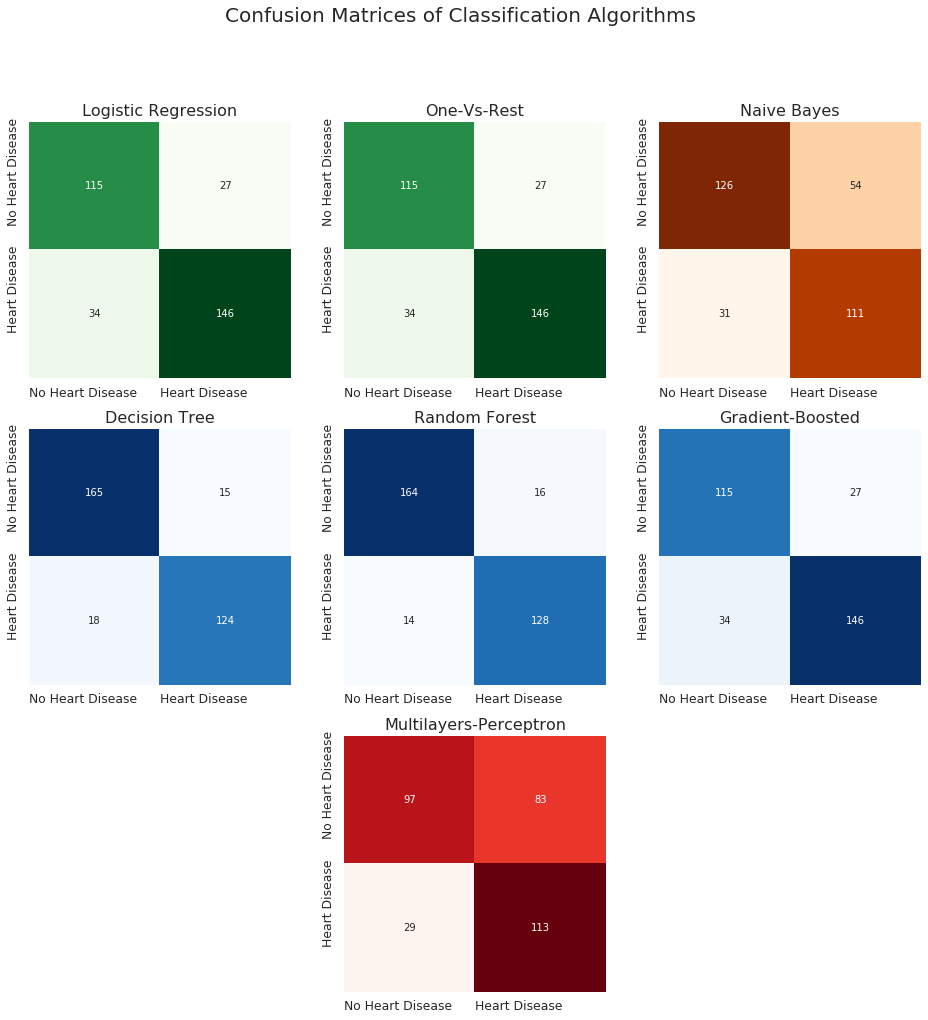

In [56]:
from sklearn.metrics import confusion_matrix

y_true_lr = predictions_lr.select("label").toPandas()
y_pred_lr = predictions_lr.select("prediction").toPandas()
c_m_lr = confusion_matrix(y_true_lr, y_pred_lr)


y_true_nb = predictions_nb.select("indexedLabel").toPandas()
y_pred_nb = predictions_nb.select("prediction").toPandas()
c_m_nb = confusion_matrix(y_true_nb, y_pred_nb)


y_true_mlp = predictions_mlp.select("indexedLabel").toPandas()
y_pred_mlp = predictions_mlp.select("prediction").toPandas()
c_m_mlp = confusion_matrix(y_true_mlp, y_pred_mlp)


y_true_dt = predictions_dt.select("indexedLabel").toPandas()
y_pred_dt = predictions_dt.select("prediction").toPandas()
c_m_dt = confusion_matrix(y_true_dt, y_pred_dt)


y_true_rf = predictions_rf.select("indexedLabel").toPandas()
y_pred_rf = predictions_rf.select("prediction").toPandas()
c_m_rf = confusion_matrix(y_true_rf, y_pred_rf)


y_true_gbt = predictions_gbt.select("indexedLabel").toPandas()
y_pred_gbt = predictions_gbt.select("prediction").toPandas()
c_m_gbt = confusion_matrix(y_true_gbt, y_pred_gbt)


y_true_ovr = predictions_ovr.select("label").toPandas()
y_pred_ovr = predictions_ovr.select("prediction").toPandas()
c_m_ovr = confusion_matrix(y_true_ovr, y_pred_ovr)

plt.figure(figsize=(16,16))
plt.suptitle("Confusion Matrices of Classification Algorithms", fontsize = 20)

plt.subplot(3,3,1)
plt.title("Logistic Regression", fontsize = 16)
sns.heatmap(c_m_lr,annot=True,cmap="Greens",fmt="d",cbar=False)
classes = ['No Heart Disease', 'Heart Disease']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, horizontalalignment='left')
plt.yticks(tick_marks, classes)

plt.subplot(3,3,2)
plt.title("One-Vs-Rest", fontsize = 16)
sns.heatmap(c_m_ovr,annot=True,cmap="Greens",fmt="d",cbar=False)
classes = ['No Heart Disease', 'Heart Disease']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, horizontalalignment='left')
plt.yticks(tick_marks, classes)

plt.subplot(3,3,3)
plt.title("Naive Bayes", fontsize = 16)
sns.heatmap(c_m_nb,annot=True,cmap="Oranges",fmt="d",cbar=False)
classes = ['No Heart Disease', 'Heart Disease']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, horizontalalignment='left')
plt.yticks(tick_marks, classes)

plt.subplot(3,3,4)
plt.title("Decision Tree", fontsize = 16)
sns.heatmap(c_m_dt,annot=True,cmap="Blues",fmt="d",cbar=False)
classes = ['No Heart Disease', 'Heart Disease']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, horizontalalignment='left')
plt.yticks(tick_marks, classes)

plt.subplot(3,3,5)
plt.title("Random Forest", fontsize = 16)
sns.heatmap(c_m_rf,annot=True,cmap="Blues",fmt="d",cbar=False)
classes = ['No Heart Disease', 'Heart Disease']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, horizontalalignment='left')
plt.yticks(tick_marks, classes)

plt.subplot(3,3,6)
plt.title("Gradient-Boosted", fontsize = 16)
sns.heatmap(c_m_ovr,annot=True,cmap="Blues",fmt="d",cbar=False)
classes = ['No Heart Disease', 'Heart Disease']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, horizontalalignment='left')
plt.yticks(tick_marks, classes)

plt.subplot(3,3,8)
plt.title("Multilayers-Perceptron", fontsize = 16)
sns.heatmap(c_m_mlp,annot=True,cmap="Reds",fmt="d",cbar=False)
classes = ['No Heart Disease', 'Heart Disease']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, horizontalalignment='left')
plt.yticks(tick_marks, classes)

plt.show()

- RDD လိုချင်ရင် အရင်ဆုံး SparkContext ကို Create
- header=True -> csv files contains the header
- inferschema=True -> sqlContext to automatically detect the data type of each column in df(if not, all columns will be read as string)

- countplot(x,hue -> variables)
- pie(autopct -> အကွက်တိုင်းရဲ့ %)
- distplot(kde=False -> distribution선 없이, hist_kws(အကွက်တိုင်းရဲ့ အနားသတ်선 색깔))

- rdd.map().toDF() -> change rdd to DF (lambda-> lambda function)
{lambda function-> can take any number of arguments, but can only have one expression.(lambda arguments : expression)}

- StringIndexer()-> string column of labels ကို column of label index로 encode함. (eg. a,b,c -> 0.0,1.0,2.0)
- VectorIndexer()-> categorical featueres in datasets of Vectors ကို index လုပ်ပေး
      (- automatically decide which features are categorical
       - convert original values to category indices)
- IndexToString()-> StringIndexer()နဲ့ပြောင်းပြန်, indexအနေနဲ့ပြောင်းထားတာကို original string ပြန်ပြောင်း
- MulticlassClassificationEvaluator-> Evaluator for multiclass classification, which expects two input columns:            prediction and label.

- metadata -> a set of data that describes and give information about other data

- <<*** Decision Tree ***>>
  *Needs labelCol and featuresCol as input columns
  *Two Features transformers(StringIndexer,VectorIndexer) to prepare the data, these help index categories for the 
   label and categorical features, adding metadata to the DataFrame which the Decision Tree Algo can recognize.
  *labelCol     -   Double Type   -  "label"       -  label to predict
   featuresCol  -   Vector Type   -  "features"    -  feature vector
   
- Pipeline-> specified as a sequence of stages, and each stage is either a Transformer or an Estimator. These stages      are run in order, and the input DataFrame is transformed as it passes through each stage. (stages=[]-> ကွင်းထဲမှာ 3ခု ရှိ    ရင် အဆင့် ၃ဆင့်) (-3~2)


- <<*** Multilayer-Perceptron ***>>
  *Use Sigmod Activation Function for HIDDEN neurons and Softmax Activation Function for OUTPUT neurons
  *(maxIter-> maximum number of iterations, blockSize-> value of param blockSize, seed-> seed for weights                 initialization if weights are not set)
  
- select().toPandas()-> collect the select row and return a pandas.DataFrame

- heatmap(annot=True-> write the data value in each cell, cmap-> color space, fmt-> string formatting code to use when    adding annotations{d-> digit number, b->binary number}, cbar-> whether to draw a colorbar)


